# HELP - Bootes Master List Creation

This notebook presents the creation of the HELP master list on the Bootes field. This field was originally ingested into HeDAM based on a masterlist produced by Eduardo Gonzales-Solares. Ken Duncan subsequently retrieved Michael Brown's precompiled masterlist for the Bootes field and therefore this notebook only contains some simple naming changes and astrometry correction. The original catalogue is described in DMU_0.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
708e28f (Tue May 8 18:05:21 2018 +0100)
This notebook was executed on: 
2018-05-09 16:08:06.517371


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict, Counter
import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, hstack, Table, vstack
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates, merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, astrometric_correction, ebv,  flux_to_mag, gen_help_id



/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "bootes_ra"
DEC_COL = "botes_dec"

## I - Column selection

In [4]:
#imported_columns = OrderedDict({
#        "objID": "ps1_id",
#        "raMean": "ps1_ra",
#        "decMean": "ps1_dec",
#
#    })


i_catalogue = Table.read("../../dmu0/dmu0_Bootes_Brown/data/Bootes_merged_Icorr_2014a_all_ap2_07112017.fits") #[list(imported_columns)]
irac_i2_catalogue = Table.read("../../dmu0/dmu0_Bootes_Brown/data/bootes_merged_ch2corr_2014a_all_ap2_07112017.fits")

help_catalogue_name = "master_catalogue_bootes_help_20180501.fits"


#for column in imported_columns:
#    catalogue[column].name = imported_columns[column]

#epoch = 2012

# Clean table metadata
#catalogue.meta = None

In [5]:
i_catalogue['id'].name = 'brown_i_id'
i_catalogue['ALPHA_J2000'].name = "ra"
i_catalogue['DELTA_J2000'].name = "dec"
i_catalogue['ra'].unit = u.deg
i_catalogue['dec'].unit = u.deg

In [6]:
i_catalogue[:10].show_in_notebook()

idx,brown_i_id,ra,dec,FLAG_DEEP,CLASS_STAR,IMAFLAGS,SEGFLAGS,m_ap_lbc_u,merr_ap_lbc_u,f_ap_lbc_u,ferr_ap_lbc_u,m_ap_mosaic_bw,merr_ap_mosaic_bw,f_ap_mosaic_bw,ferr_ap_mosaic_bw,m_ap_mosaic_r,merr_ap_mosaic_r,f_ap_mosaic_r,ferr_ap_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,f_ap_mosaic_i,ferr_ap_mosaic_i,m_ap_prime90_z,merr_ap_prime90_z,f_ap_prime90_z,ferr_ap_prime90_z,m_ap_suprime_z,merr_ap_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_ap_lbc_y,merr_ap_lbc_y,f_ap_lbc_y,ferr_ap_lbc_y,m_ap_newfirm_j,merr_ap_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,m_ap_newfirm_h,merr_ap_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,m_ap_onis_k,merr_ap_onis_k,f_ap_onis_k,ferr_ap_onis_k,m_ap_newfirm_k,merr_ap_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,m_ap_irac_ch1,merr_ap_irac_ch1,f_ap_irac_ch1,ferr_ap_irac_ch1,m_ap_irac_ch2,merr_ap_irac_ch2,f_ap_irac_ch2,ferr_ap_irac_ch2,m_ap_irac_ch3,merr_ap_irac_ch3,f_ap_irac_ch3,ferr_ap_irac_ch3,m_ap_irac_ch4,merr_ap_irac_ch4,f_ap_irac_ch4,ferr_ap_irac_ch4
,,deg,deg,,,,,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy
0,1,216.473863,32.2825963,0,0.64,1,0,25.3294,-99.0,0.0765911,0.0957339,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.6871,0.1773,1.21658,0.198666,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.544,-99.0,0.114963,0.636561,23.1026,-99.0,0.120575,0.981891,21.0877,-99.0,3.42072,4.95589,20.3206,-99.0,8.53047,9.24751
1,2,216.6176098,32.2827433,0,0.66,1,21,25.2766,-99.0,0.0674122,0.107004,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.563,0.1801,1.36389,0.22624,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.428,-99.0,1.85771,1.01104,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.7807,-99.0,0.560893,1.12133,23.5937,-99.0,-0.841274,1.08362,21.172,-99.0,-1.24887,6.79294,21.0885,-99.0,-4.71642,9.01942
2,3,216.6229261,32.2827587,0,0.95,1,0,27.024,-99.0,-0.172496,0.11439,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.6079,0.2358,1.30864,0.284211,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.4042,0.3129,3.96587,1.14293,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.0248,-99.0,0.0582638,1.09041,23.3361,-99.0,-0.450296,1.06563,21.9414,-99.0,-6.4583,6.26595,20.8749,-99.0,-1.74025,8.9797
3,4,216.6170473,32.2827598,0,0.81,1,0,26.4913,-99.0,-0.124479,0.108206,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.3939,0.1541,1.59375,0.226203,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.9429,0.4547,2.41446,1.01116,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.6654,-99.0,0.97427,1.07169,23.2841,-99.0,-0.29979,1.0316,21.5816,-99.0,-5.15037,6.80526,21.1196,-99.0,-4.89432,8.92056
4,5,216.6101975,32.2827674,0,0.94,1,2,25.7669,-99.0,-0.0370969,0.108127,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.5912,0.1569,1.32893,0.192043,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.9563,0.3442,2.38506,0.756112,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.7029,-99.0,0.855066,1.07846,22.7077,-99.0,0.705761,1.14639,21.3186,-99.0,-5.7884,8.28326,20.5633,-99.0,2.94478,9.33336
5,6,216.5465545,32.2827939,0,0.71,1,10,24.7405,0.2036,0.461125,0.0864713,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.0635,0.0782635,2.16063,0.155745,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.7609,-99.0,-0.359235,0.74796,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,21.911,0.1264,6.24596,0.727147,22.2414,0.2474,4.60742,1.04986,21.1104,-99.0,-0.332322,6.69488,20.5462,-99.0,8.46004,6.74708
6,7,216.6220666,32.2827948,0,0.96,1,0,25.4731,-99.0,0.00950819,0.112663,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.5671,0.2271,1.35875,0.284206,-99.0,-99.

In [7]:
irac_i2_catalogue['id'].name = 'brown_irac_id'
irac_i2_catalogue['ALPHA_J2000'].unit = u.deg
irac_i2_catalogue['DELTA_J2000'].unit = u.deg

In [8]:
irac_i2_catalogue[:10].show_in_notebook()

idx,brown_irac_id,ALPHA_J2000,DELTA_J2000,IMAFLAGS,SEGFLAGS,m_ap_lbc_u,merr_ap_lbc_u,f_ap_lbc_u,ferr_ap_lbc_u,m_ap_mosaic_bw,merr_ap_mosaic_bw,f_ap_mosaic_bw,ferr_ap_mosaic_bw,m_ap_mosaic_r,merr_ap_mosaic_r,f_ap_mosaic_r,ferr_ap_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,f_ap_mosaic_i,ferr_ap_mosaic_i,m_ap_prime90_z,merr_ap_prime90_z,f_ap_prime90_z,ferr_ap_prime90_z,m_ap_suprime_z,merr_ap_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_ap_lbc_y,merr_ap_lbc_y,f_ap_lbc_y,ferr_ap_lbc_y,m_ap_newfirm_j,merr_ap_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,m_ap_newfirm_h,merr_ap_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,m_ap_onis_k,merr_ap_onis_k,f_ap_onis_k,ferr_ap_onis_k,m_ap_newfirm_k,merr_ap_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,m_ap_irac_ch1,merr_ap_irac_ch1,f_ap_irac_ch1,ferr_ap_irac_ch1,m_ap_irac_ch2,merr_ap_irac_ch2,f_ap_irac_ch2,ferr_ap_irac_ch2,m_ap_irac_ch3,merr_ap_irac_ch3,f_ap_irac_ch3,ferr_ap_irac_ch3,m_ap_irac_ch4,merr_ap_irac_ch4,f_ap_irac_ch4,ferr_ap_irac_ch4
,,deg,deg,,,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy
0,1,217.5665371,32.117202,5,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,21.8227566382,0.3133,6.77481350724,1.95493994077,-99.0,-99.0,-99.0,-99.0,19.3435866264,-99.0,31.6411819493,17.4097925571
1,2,216.1924704,32.1071896,6,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,20.7889566382,0.0947,17.5556674154,1.53123907719,-99.0,-99.0,-99.0,-99.0,20.1495976355,-99.0,5.51636123756,13.0590683324
2,3,216.2097384,32.1080726,4,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,21.9249566382,0.2392,6.16619627748,1.35848297506,-99.0,-99.0,-99.0,-99.0,20.1281753971,-99.0,11.5327452293,10.3660594718
3,4,216.2048572,32.1082895,6,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.4816566382,0.4211,3.69264318776,1.4321821816,-99.0,-99.0,-99.0,-99.0,20.7232067928,-99.0,-6.76725743805,12.7094542684
4,5,216.592738,32.1131399,5,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.0409566382,0.3882,5.54137249505,1.98129231866,-99.0,-99.0,-99.0,-99.0,20.1004531708,-99.0,-1.69688612318,17.3980901074
5,6,216.5893936,32.1132923,5,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,20.9708566382,0.1276,14.8476371197,1.74495286071,-99.0,-99.0,-99.0,-99.0,19.5326385559,-99.0,15.9430973557,19.9483978362
6,7,216.6887551,32.1133444,5,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99

## II - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Bootes.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


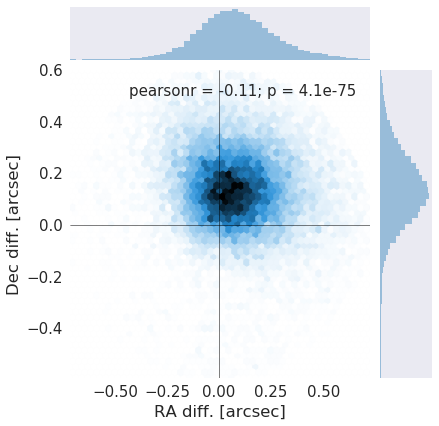

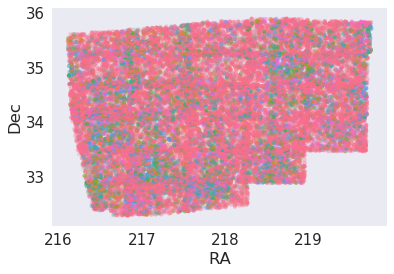

In [10]:
nb_astcor_diag_plot(i_catalogue["ra"], i_catalogue["dec"], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(i_catalogue["ra"], i_catalogue["dec"]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.0735978168904694 arcsec
Dec correction: -0.12698051759514328 arcsec


In [12]:
i_catalogue["ra"] = i_catalogue["ra"] + delta_ra.to(u.deg)
i_catalogue["dec"] = i_catalogue["dec"] + delta_dec.to(u.deg)

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


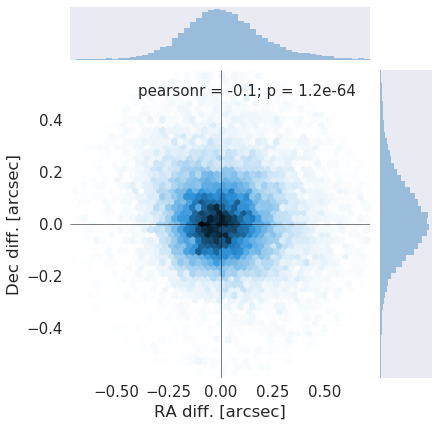

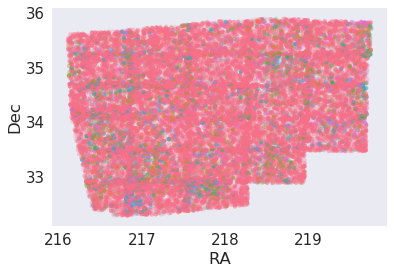

In [13]:
nb_astcor_diag_plot(i_catalogue["ra"], i_catalogue["dec"], 
                    gaia_coords.ra, gaia_coords.dec)

We then correct the other catalogue

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


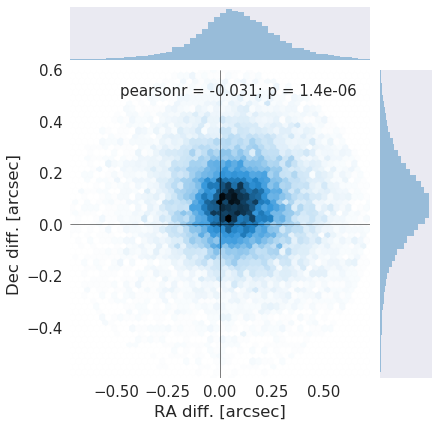

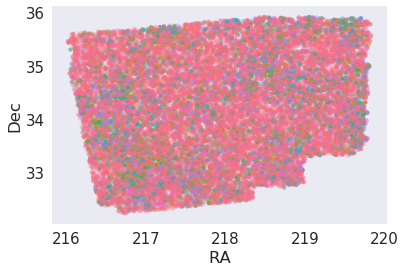

In [14]:
nb_astcor_diag_plot(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"], 
                    gaia_coords.ra, gaia_coords.dec)

In [15]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.07916888162640134 arcsec
Dec correction: -0.08063874360573209 arcsec


In [16]:
irac_i2_catalogue["ALPHA_J2000"] = irac_i2_catalogue["ALPHA_J2000"] + delta_ra.to(u.deg)
irac_i2_catalogue["DELTA_J2000"] = irac_i2_catalogue["DELTA_J2000"] + delta_dec.to(u.deg)

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


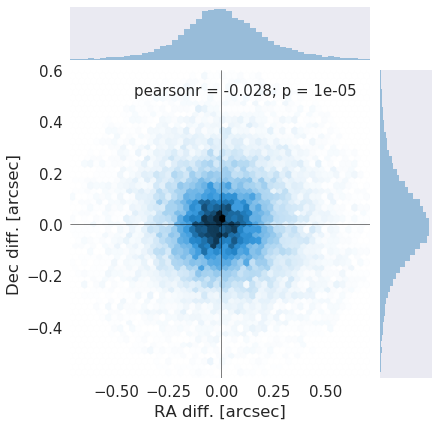

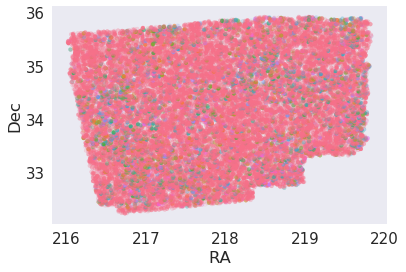

In [17]:
nb_astcor_diag_plot(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"], 
                    gaia_coords.ra, gaia_coords.dec)

## III Merging

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


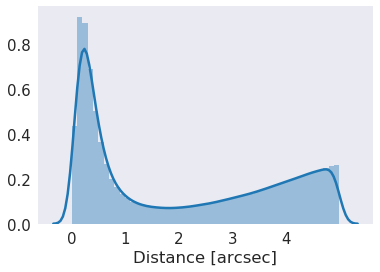

In [18]:
nb_merge_dist_plot(
    SkyCoord(i_catalogue['ra'], i_catalogue['dec']),
    SkyCoord(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"] )
)

In [19]:
radius = 1.0*u.arcsec
coords_1 = SkyCoord(i_catalogue['ra'], i_catalogue['dec'])

coords_2 = SkyCoord(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"])

# Search for sources in second catalogue matching the sources in the first
# one.
idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

# We want to flag the possible mis-associations, i.e. the sources in each
# catalogue that are associated to several sources in the other one, but
# also all the sources that are associated to a problematic source in the
# other catalogue (e.g. if two sources in the first catalogue are
# associated to the same source in the second catalogue, they must be
# flagged as potentially problematic).
#
# Search for duplicate associations
toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
# Flagging the sources associated to duplicates
dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
toflag_idx_1 = np.unique(np.concatenate(
    (toflag_idx_1, idx_1[dup_associated_in_idx1])
))
toflag_idx_2 = np.unique(np.concatenate(
    (toflag_idx_2, idx_2[dup_associated_in_idx2])
))

# Adding the flags to the catalogue.  In the second catalogue, the column
# is named "flag_merged_2" and will be combined to the flag_merged column
# one the merge is done.
try:
    i_catalogue["flag_merged"] |= np.in1d(np.arange(len(i_catalogue), dtype=int),
                                        toflag_idx_1)
except KeyError:
    i_catalogue.add_column(Column(
        data=np.in1d(np.arange(len(i_catalogue), dtype=int), toflag_idx_1),
        name="flag_merged"
    ))
irac_i2_catalogue.add_column(Column(
    data=np.in1d(np.arange(len(irac_i2_catalogue), dtype=int), toflag_idx_2),
       name="flag_merged_2"
))

# Now that we have flagged the maybe spurious associations, we want to
# associate each source of each catalogue to at most one source in the
# other one.

# We sort the indices by the distance to take the nearest counterparts in
# the following steps.
sort_idx = np.argsort(d2d)
idx_1 = idx_1[sort_idx]
idx_2 = idx_2[sort_idx]

# These array will contain the indexes of the matching sources in both
# catalogues.
match_idx_1 = np.array([], dtype=int)
match_idx_2 = np.array([], dtype=int)

while len(idx_1) > 0:

    both_first_idx = np.sort(np.intersect1d(
         np.unique(idx_1, return_index=True)[1],
         np.unique(idx_2, return_index=True)[1],
    ))

    new_match_idx_1 = idx_1[both_first_idx]
    new_match_idx_2 = idx_2[both_first_idx]

    match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
    match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

    # We remove the matching sources in both catalogues.
    to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
    idx_1 = idx_1[~to_remove]
    idx_2 = idx_2[~to_remove]

# Indices of un-associated object in both catalogues.
unmatched_idx_1 = np.delete(np.arange(len(i_catalogue), dtype=int),match_idx_1)
unmatched_idx_2 = np.delete(np.arange(len(irac_i2_catalogue), dtype=int),match_idx_2)

# Sources only in cat_1
only_in_cat_1 = i_catalogue[unmatched_idx_1]

# Sources only in cat_2
only_in_cat_2 = irac_i2_catalogue[unmatched_idx_2]
# We are using the ra and dec columns from cat_2 for the position.
only_in_cat_2["ALPHA_J2000"].name = "ra"
only_in_cat_2["DELTA_J2000"].name = "dec"

# Where we have an association we take the values from the i selected catalogue.
both_in_cat_1_and_cat_2 = i_catalogue[match_idx_1] #hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
# We don't need the positions from the second catalogue anymore.
#both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

# Logging the number of rows
print("There are {} sources only in the first catalogue".format(len(only_in_cat_1)))
print("There are {} sources only in the second catalogue".format(len(only_in_cat_2)))
print("There are {} sources in both catalogues".format(len(both_in_cat_1_and_cat_2)))

merged_catalogue = vstack([only_in_cat_1,  both_in_cat_1_and_cat_2,
                               only_in_cat_2])

# When vertically stacking the catalogues, some values in the flag columns
# are masked because they did not exist in the catalogue some row originate
# from. We must set them to the appropriate value.
for colname in merged_catalogue.colnames:
    if 'flag' in colname:
        merged_catalogue[colname][merged_catalogue[colname].mask] = False

# We combined the flag_merged flags
merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
merged_catalogue.remove_column('flag_merged_2')

There are 1580405 sources only in the first catalogue
There are 185203 sources only in the second catalogue
There are 486485 sources in both catalogues


In [20]:
# Replace -99 values
for col in merged_catalogue.colnames:
    if col.startswith('m_'):
        errcol = "merr{}".format(col[1:])
        merged_catalogue[col][merged_catalogue[col] < -90.] = np.nan
        merged_catalogue[errcol][merged_catalogue[errcol] < -90.] = np.nan
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        merged_catalogue[col][merged_catalogue[col] < -90.] = np.nan
        merged_catalogue[errcol][merged_catalogue[errcol] < -90.] = np.nan
        


/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site

## IV - Removal of duplicated sources

In [21]:
merged_catalogue.add_column(Column(np.full(len(merged_catalogue), "Brown", dtype='<U18'), name='stellarity_origin'))


In [22]:
merged_catalogue['CLASS_STAR'].name = 'stellarity'

orginal_length = len(merged_catalogue)
mask = merged_catalogue['FLAG_DEEP'] == 1
merged_catalogue = merged_catalogue[mask]
print("There were {} sources in total and {} after removing all sources that didn't have FLAG_DEEP == 1".format(orginal_length, len(merged_catalogue)))
merged_catalogue.remove_columns(['FLAG_DEEP', 'IMAFLAGS', 'SEGFLAGS'])

There were 2252093 sources in total and 1657478 after removing all sources that didn't have FLAG_DEEP == 1


In [23]:
SORT_COLS = ['merr_ap_lbc_u',
             'merr_ap_mosaic_bw',
             'merr_ap_mosaic_r',
             'merr_ap_mosaic_i',
             'merr_ap_prime90_z',
             'merr_ap_suprime_z',
             'merr_ap_lbc_y',
             'merr_ap_newfirm_j',
             'merr_ap_newfirm_h',
             'merr_ap_onis_k',
             'merr_ap_newfirm_k',
             'merr_ap_irac_ch1',
             'merr_ap_irac_ch2',
             'merr_ap_irac_ch3',
             'merr_ap_irac_ch4']
FLAG_NAME = 'flag_cleaned'

nb_orig_sources = len(merged_catalogue)

merged_catalogue = remove_duplicates(merged_catalogue, 'ra', 'dec',  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(merged_catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(merged_catalogue[FLAG_NAME])))

The initial catalogue had 1657478 sources.
The cleaned catalogue has 1657470 sources (8 removed).
The cleaned catalogue has 8 sources flagged as having been cleaned


### Rename Columns

In [24]:
replacements = [
   # ['_lbc_', '_lbcb_'],
    ['_onis_k', '_tifkam_ks'],
    ['_irac_ch', '_irac_i'],
    ['_prime90_', '_90prime_'],
    ['_mosaic_bw', '_mosaic_b'],
]
for col in merged_catalogue.colnames:
    for rep in replacements:
        if rep[0] in col:
            merged_catalogue.rename_column(col, col.replace(rep[0], rep[1]))

In [25]:
merged_catalogue[:10].show_in_notebook()

idx,brown_i_id,ra,dec,stellarity,m_ap_lbcb_u,merr_ap_lbcb_u,f_ap_lbcb_u,ferr_ap_lbcb_u,m_ap_mosaic_b,merr_ap_mosaic_b,f_ap_mosaic_b,ferr_ap_mosaic_b,m_ap_mosaic_r,merr_ap_mosaic_r,f_ap_mosaic_r,ferr_ap_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,f_ap_mosaic_i,ferr_ap_mosaic_i,m_ap_90prime_z,merr_ap_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_ap_suprime_z,merr_ap_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_ap_lbcb_y,merr_ap_lbcb_y,f_ap_lbcb_y,ferr_ap_lbcb_y,m_ap_newfirm_j,merr_ap_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,m_ap_newfirm_h,merr_ap_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,m_ap_tifkam_ks,merr_ap_tifkam_ks,f_ap_tifkam_ks,ferr_ap_tifkam_ks,m_ap_newfirm_k,merr_ap_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,m_ap_irac_i1,merr_ap_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i2,merr_ap_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_ap_irac_i4,merr_ap_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,flag_merged,brown_irac_id,stellarity_origin,flag_cleaned
,,deg,deg,,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,,,
0,738918,216.490157956,33.7739744276,0.95,17.746055603,0.000173507403815,289.452850342,0.0462563745677,17.7428970337,0.000214838903048,290.295776367,0.0574419684708,17.7354354858,0.000500445894431,292.29800415,0.134728252888,17.6347465515,0.000415595801314,320.701446533,0.122757427394,17.2844543457,0.00105345598422,442.81036377,0.429645091295,19.2643127441,0.00452686706558,71.4947891235,0.298090308905,17.6433525085,0.00129694503266,318.169952393,0.380063742399,17.3310012817,0.00175447098445,424.228149414,0.685521960258,17.1474666595,0.00307767698541,502.357818604,1.42400622368,nan,nan,nan,nan,16.6635894775,0.00350280990824,784.44708252,2.53078889847,16.0055007935,0.000447837490356,1438.13452148,0.593192517757,15.8097572327,0.000600092171226,1722.25292969,0.951898336411,15.3539037704,0.002082278952,2620.82617188,5.02635097504,14.8761672974,0.00195277004968,4069.42382812,7.31913471222,False,--,Brown,False
1,1082641,217.137540856,34.2566858276,1.0,17.8731536865,0.000187710902537,257.476715088,0.0445146709681,17.2846984863,8.99571023183e-05,442.711425781,0.0366802178323,16.4193344116,0.000115004899271,982.350524902,0.104053936899,16.5519485474,0.000208811004995,869.402160645,0.167205199599,16.3224563599,0.000647459819447,1074.0333252,0.640480995178,19.3456115723,0.00289126695134,66.3368759155,0.176652148366,16.4167518616,0.000612586911302,984.68963623,0.555575072765,16.3726005554,0.00134036003146,1025.55712891,1.26606810093,16.5438671112,0.00161963899154,875.896789551,1.30661261082,16.5337333679,0.0163362398744,884.11114502,13.3025426865,16.9790916443,0.00399711821228,586.62890625,2.15966391563,18.0085010529,0.0031473368872,227.300048828,0.658898353577,18.4589576721,0.00611610803753,150.112533569,0.845605373383,18.7473049164,0.0575773492455,115.100662231,6.1038684845,19.1206684113,0.114500001073,81.607925415,8.60624027252,False,--,Brown,False
2,1090977,217.203011156,34.2695855276,1.0,17.8218536377,0.000189480706467,269.934387207,0.047108463943,17.2361984253,7.8341072367e-05,462.935852051,0.0334030427039,16.427734375,0.000122904602904,974.779052734,0.110344335437,16.4840488434,0.000182844101801,925.508483887,0.155860856175,16.2851543427,0.000500391877722,1111.57299805,0.512299537659,19.3137111664,0.00234233494848,68.3148574829,0.147380441427,16.28125,0.000423109595431,1115.5769043,0.434738516808,16.2785015106,0.00108670198824,1118.40600586,1.11940097809,16.4311676025,0.00117668195162,971.702087402,1.05309581757,16.4401321411,0.0123616103083,963.711914062,10.9723072052,16.8771896362,0.00478344783187,644.352416992,2.83883547783,18.0129013062,0.00235240301117,226.38079834,0.490486443043,18.4433574677,0.00821091327816,152.284881592,1.15165913105,18.7510051727,0.0575192309916,114.709060669,6.07696199417,19.2016677856,0.135800004005,75.741

## IV b - Estimating total magnitudes

After finding that the aperture matched Brown catalogue produced superior photometric redshifts we decided to use that catalogue as the principle help masterlist on Bootes. Since Cigale requires total magnitudes we will here take the mosaic_i band fluxes and use the ratio to produce approximate total magnitudes.

In [26]:

help_imported_columns  = OrderedDict({
        "help_id": "full_help_id",
        "ra": "full_help_ra",
        "dec": "full_help_dec",
        "stellarity":  "full_help_stellarity",
            "f_ap_mosaic_i": "full_help_f_ap_mosaic_i", 
        "ferr_ap_mosaic_i": "full_help_ferr_ap_mosaic_i", 
        "f_mosaic_i": "full_help_f_mosaic_i", 
        "ferr_mosaic_i": "full_help_ferr_mosaic_i",
    })


help_catalogue = Table.read("./data/{}")[list(help_imported_columns,help_catalogue_name)]
for column in help_imported_columns:
    help_catalogue[column].name = help_imported_columns[column]


# Clean table metadata
help_catalogue.meta = None

In [27]:
total_to_ap = help_catalogue['full_help_f_mosaic_i'] / help_catalogue['full_help_f_ap_mosaic_i']
help_catalogue.add_column(Column(total_to_ap,
                                   name="full_help_total_to_ap_mosaic_i"))



/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


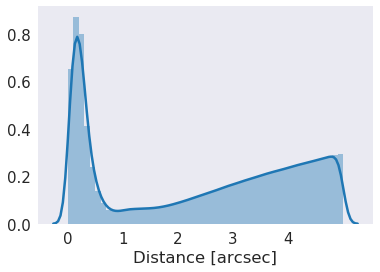

In [28]:
nb_merge_dist_plot(
    SkyCoord(merged_catalogue['ra'], merged_catalogue['dec']),
    SkyCoord(help_catalogue['full_help_ra'], help_catalogue['full_help_dec'])
)

In [29]:

# Given the graph above, we use 0.8 arc-second radius# Given  
merged_catalogue = merge_catalogues(merged_catalogue, help_catalogue, "full_help_ra", "full_help_dec", radius=0.8*u.arcsec)




id_names = []
for col in merged_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
        merged_catalogue[col].fill_value = -1
    elif (col.startswith("m_") or 
          col.startswith("merr_") or 
          col.startswith("f_") or 
          col.startswith("ferr_") or 
          col.startswith("stellarity") ):
        merged_catalogue[col].fill_value = np.nan
    elif 'flag' in col:
        merged_catalogue[col].fill_value = 0
        

        
        
merged_catalogue["full_help_total_to_ap_mosaic_i"].fill_value = np.nan

merged_catalogue = merged_catalogue.filled()

In [30]:
tot_to_ap = merged_catalogue['full_help_total_to_ap_mosaic_i']
tot_to_ap[np.isnan(tot_to_ap)] = 1.

for col in merged_catalogue.colnames:
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        f_ap = merged_catalogue[col]
        ferr_ap = merged_catalogue[errcol]

        ftot = np.array(f_ap) * np.array(tot_to_ap)
        ferrtot = np.array(ftot) * (np.array(ferr_ap) / np.array(f_ap))

        #Add the total flux and error columns
        merged_catalogue.add_column(Column(ftot, name=col.replace('_ap_', '_')))
        merged_catalogue.add_column(Column(ferrtot, name=errcol.replace('_ap_', '_')))
        
        
        #Add the total mag and error columns
        mtot, merrtot = flux_to_mag( ftot/1.e6, ferrtot/1.e6)

        merged_catalogue.add_column(Column(mtot, name="m{}".format(col[1:]).replace('_ap_', '_')))
        merged_catalogue.add_column(Column(merrtot, name="m{}".format(errcol[1:]).replace('_ap_', '_')))
        
        
merged_catalogue.remove_columns(["full_help_stellarity",
                                 "full_help_f_ap_mosaic_i", 
                                 "full_help_ferr_ap_mosaic_i", 
                                 "full_help_f_mosaic_i", 
                                 "full_help_ferr_mosaic_i",
                                 "full_help_total_to_ap_mosaic_i"])
        
    

/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [31]:

merged_catalogue

brown_i_id,ra,dec,stellarity,m_ap_lbcb_u,merr_ap_lbcb_u,f_ap_lbcb_u,ferr_ap_lbcb_u,m_ap_mosaic_b,merr_ap_mosaic_b,f_ap_mosaic_b,ferr_ap_mosaic_b,m_ap_mosaic_r,merr_ap_mosaic_r,f_ap_mosaic_r,ferr_ap_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,f_ap_mosaic_i,ferr_ap_mosaic_i,m_ap_90prime_z,merr_ap_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_ap_suprime_z,merr_ap_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_ap_lbcb_y,merr_ap_lbcb_y,f_ap_lbcb_y,ferr_ap_lbcb_y,m_ap_newfirm_j,merr_ap_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,m_ap_newfirm_h,merr_ap_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,m_ap_tifkam_ks,merr_ap_tifkam_ks,f_ap_tifkam_ks,ferr_ap_tifkam_ks,m_ap_newfirm_k,merr_ap_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,m_ap_irac_i1,merr_ap_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i2,merr_ap_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_ap_irac_i4,merr_ap_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,flag_merged,brown_irac_id,stellarity_origin,flag_cleaned,full_help_id,f_lbcb_u,ferr_lbcb_u,m_lbcb_u,merr_lbcb_u,f_mosaic_b,ferr_mosaic_b,m_mosaic_b,merr_mosaic_b,f_mosaic_r,ferr_mosaic_r,m_mosaic_r,merr_mosaic_r,f_mosaic_i,ferr_mosaic_i,m_mosaic_i,merr_mosaic_i,f_90prime_z,ferr_90prime_z,m_90prime_z,merr_90prime_z,f_suprime_z,ferr_suprime_z,m_suprime_z,merr_suprime_z,f_lbcb_y,ferr_lbcb_y,m_lbcb_y,merr_lbcb_y,f_newfirm_j,ferr_newfirm_j,m_newfirm_j,merr_newfirm_j,f_newfirm_h,ferr_newfirm_h,m_newfirm_h,merr_newfirm_h,f_tifkam_ks,ferr_tifkam_ks,m_tifkam_ks,merr_tifkam_ks,f_newfirm_k,ferr_newfirm_k,m_newfirm_k,merr_newfirm_k,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4
,deg,deg,,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,str18,bool,bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
394263,216.251188956,33.1766217276,0.99,19.0193538666,0.000440979812993,89.5896987915,0.0363875217736,18.5135993958,0.000293097196845,142.744781494,0.0385343134403,17.8090343475,0.000415282003814,273.140686035,0.104473270476,17.5528488159,0.000735500885639,345.828338623,0.234271526337,20.1309547424,0.0438946001232,32.1823616028,1.30108213425,20.3337135315,0.00626260181889,26.7002105713,0.154008671641,17.50025177,0.00127886899281,362.994140625,0.427564263344,17.7179012299,0.00277148210444,297.056884766,0.758276164532,17.8028678894,0.00332769891247,274.69631958,0.841923415661,nan,nan,nan,nan,18.2008895874,0.0134822996333,190.389923096,2.36419701576,19.2748012543,0.0111739197746,70.8075027466,0.728719770908,19.6790561676,0.0194622091949,48.7952308655,0.874671936035,20.0587043762,0.165800005198,34.3968238831,5.25265169144,20.1651668549,0.22990000248,31.1840724945,6.60309457779,False,-1,Brown,False,-1,89.5896987915,0.0363875217736,19.0193

## V - Flagging Gaia objects

In [32]:
merged_catalogue.add_column(
    gaia_flag_column(SkyCoord(merged_catalogue["ra"], merged_catalogue["dec"]), 2012, gaia)
)

In [33]:
print("{} sources flagged.".format(np.sum(merged_catalogue["flag_gaia"] > 0)))

43420 sources flagged.


## VI - Adding E(B-V) column

In [34]:

merged_catalogue.add_column(
    ebv(merged_catalogue['ra'], merged_catalogue['dec'])
)


# VII - Adding HELP unique identifiers and field columns

In [35]:
merged_catalogue.add_column(Column(gen_help_id(merged_catalogue['ra'], merged_catalogue['dec']),
                                   name="help_id"))
merged_catalogue.add_column(Column(np.full(len(merged_catalogue), "Bootes", dtype='<U18'),
                                   name="field"))

In [36]:
# Check that the HELP Ids are unique
if len(merged_catalogue) != len(np.unique(merged_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## VIII - Cross-matching with spec-z catalogue

In [37]:
specz =  Table.read("../../dmu23/dmu23_Bootes/data/Bootes-specz-v2.4.csv")

In [38]:
specz.rename_column('RA', 'ra')
specz.rename_column('DEC', 'dec')
specz.rename_column('OBJID', 'specz_id')
specz.rename_column('Z_SPEC', 'z_spec')
specz.rename_column('Z_SOURCE', 'z_source')
specz.rename_column('Z_QUAL', 'z_qual')
specz.rename_column('REL', 'rel')
specz.rename_column('AGN', 'agn')

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


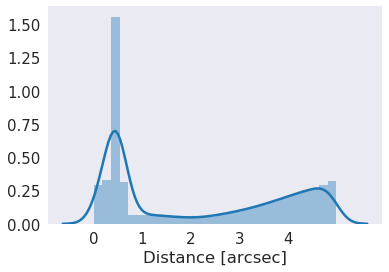

In [39]:
nb_merge_dist_plot(
    SkyCoord(merged_catalogue['ra'], merged_catalogue['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [40]:
merged_catalogue = specz_merge(merged_catalogue, specz, radius=1. * u.arcsec)


## IX - Cross-identification table
We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogues. This can be used to easily get additional information from them.

For convenience, we also cross-match the master list with the SDSS catalogue and add the objID associated with each source, if any.

In [41]:

##
 # Addind SDSS ids# Addind 
#
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_Bootes.fits")['objID', 'ra', 'dec']
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)
idx_ml, d2d, _ = sdss_coords.match_to_catalog_sky(SkyCoord(merged_catalogue['ra'], merged_catalogue['dec']))
idx_sdss = np.arange(len(sdss))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss = idx_sdss[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss = idx_sdss[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss = idx_sdss[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
merged_catalogue.add_column(Column(data=np.full(len(merged_catalogue), -1, dtype='>i8'), name="sdss_id"))
merged_catalogue['sdss_id'][idx_ml] = sdss['objID'][idx_sdss]

282 master list rows had multiple associations.


In [42]:

id_names = []
for col in merged_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
        merged_catalogue[col].fill_value = -1

        
        
print(id_names)


        
merged_catalogue = merged_catalogue.filled()



['brown_i_id', 'brown_irac_id', 'full_help_id', 'help_id', 'specz_id', 'sdss_id']


In [43]:
mask = np.bitwise_and(merged_catalogue['brown_i_id'] == -1 , merged_catalogue['brown_irac_id'] == -1)
merged_catalogue['help_id'][mask] = -1
without_ndwfs = len(merged_catalogue)

merged_catalogue[id_names].write(
    "{}/master_list_cross_ident_bootes_brown{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)
id_names.remove('help_id')
merged_catalogue.remove_columns(id_names)

merged_catalogue = merged_catalogue[~mask]

print("There were a total of {} objects before and {} after removing those that are not in the Brown catalogue".format(without_ndwfs, len(merged_catalogue)))

There were a total of 3481661 objects before and 1657470 after removing those that are not in the Brown catalogue


### VIII.a Wavelength domain coverage
We add a binary flag_optnir_obs indicating that a source was observed in a given wavelength domain:

1 for observation in optical;
2 for observation in near-infrared;
4 for observation in mid-infrared (IRAC).
It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.

Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.

In [44]:

merged_catalogue.add_column(
    Column(
        data=np.full(len(merged_catalogue), 7),
        name="flag_optnir_obs")
)

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(1657470, 7) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


### VIII.b Wavelength domain detection
We add a binary flag_optnir_det indicating that a source was detected in a given wavelength domain:

1 for detection in optical;
2 for detection in near-infrared;
4 for detection in mid-infrared (IRAC).
It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in at least two bands. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [45]:
for col in merged_catalogue.colnames:
    if col.startswith('merr_'):
        print(col)

merr_ap_lbcb_u
merr_ap_mosaic_b
merr_ap_mosaic_r
merr_ap_mosaic_i
merr_ap_90prime_z
merr_ap_suprime_z
merr_ap_lbcb_y
merr_ap_newfirm_j
merr_ap_newfirm_h
merr_ap_tifkam_ks
merr_ap_newfirm_k
merr_ap_irac_i1
merr_ap_irac_i2
merr_ap_irac_i3
merr_ap_irac_i4
merr_lbcb_u
merr_mosaic_b
merr_mosaic_r
merr_mosaic_i
merr_90prime_z
merr_suprime_z
merr_lbcb_y
merr_newfirm_j
merr_newfirm_h
merr_tifkam_ks
merr_newfirm_k
merr_irac_i1
merr_irac_i2
merr_irac_i3
merr_irac_i4


In [46]:
nb_optical_flux = (
  
    
    1 * ~np.isnan(merged_catalogue['f_ap_90prime_z']) +
    
    1 * ~np.isnan(merged_catalogue['f_ap_mosaic_r']) +
    1 * ~np.isnan(merged_catalogue['f_ap_mosaic_i']) +
    1 * ~np.isnan(merged_catalogue['f_ap_mosaic_b']) +
    
    1 * ~np.isnan(merged_catalogue['f_ap_lbcb_u']) +
    1 * ~np.isnan(merged_catalogue['f_ap_lbcb_y']) 
  
    

)

nb_nir_flux = (
    1 * ~np.isnan(merged_catalogue['f_ap_newfirm_j']) +
    1 * ~np.isnan(merged_catalogue['f_ap_newfirm_h']) +
    1 * ~np.isnan(merged_catalogue['f_ap_newfirm_k']) +
    
    1 * ~np.isnan(merged_catalogue['f_ap_tifkam_ks']) 

)

nb_mir_flux = (
    1 * ~np.isnan(merged_catalogue['f_ap_irac_i1']) +
    1 * ~np.isnan(merged_catalogue['f_ap_irac_i2']) +
    1 * ~np.isnan(merged_catalogue['f_ap_irac_i3']) +
    1 * ~np.isnan(merged_catalogue['f_ap_irac_i4'])
)

In [47]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

merged_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

### X - Adding HEALPix index¶
We are adding a column with a HEALPix index at order 13 associated with each source.



In [48]:

merged_catalogue.add_column(Column(
    data=coords_to_hpidx(merged_catalogue['ra'], merged_catalogue['dec'], order=13),
    name="hp_idx"
))

In [49]:
merged_catalogue[:10].show_in_notebook()

idx,ra,dec,stellarity,m_ap_lbcb_u,merr_ap_lbcb_u,f_ap_lbcb_u,ferr_ap_lbcb_u,m_ap_mosaic_b,merr_ap_mosaic_b,f_ap_mosaic_b,ferr_ap_mosaic_b,m_ap_mosaic_r,merr_ap_mosaic_r,f_ap_mosaic_r,ferr_ap_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,f_ap_mosaic_i,ferr_ap_mosaic_i,m_ap_90prime_z,merr_ap_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_ap_suprime_z,merr_ap_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_ap_lbcb_y,merr_ap_lbcb_y,f_ap_lbcb_y,ferr_ap_lbcb_y,m_ap_newfirm_j,merr_ap_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,m_ap_newfirm_h,merr_ap_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,m_ap_tifkam_ks,merr_ap_tifkam_ks,f_ap_tifkam_ks,ferr_ap_tifkam_ks,m_ap_newfirm_k,merr_ap_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,m_ap_irac_i1,merr_ap_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i2,merr_ap_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_ap_irac_i4,merr_ap_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,flag_merged,stellarity_origin,flag_cleaned,f_lbcb_u,ferr_lbcb_u,m_lbcb_u,merr_lbcb_u,f_mosaic_b,ferr_mosaic_b,m_mosaic_b,merr_mosaic_b,f_mosaic_r,ferr_mosaic_r,m_mosaic_r,merr_mosaic_r,f_mosaic_i,ferr_mosaic_i,m_mosaic_i,merr_mosaic_i,f_90prime_z,ferr_90prime_z,m_90prime_z,merr_90prime_z,f_suprime_z,ferr_suprime_z,m_suprime_z,merr_suprime_z,f_lbcb_y,ferr_lbcb_y,m_lbcb_y,merr_lbcb_y,f_newfirm_j,ferr_newfirm_j,m_newfirm_j,merr_newfirm_j,f_newfirm_h,ferr_newfirm_h,m_newfirm_h,merr_newfirm_h,f_tifkam_ks,ferr_tifkam_ks,m_tifkam_ks,merr_tifkam_ks,f_newfirm_k,ferr_newfirm_k,m_newfirm_k,merr_newfirm_k,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,flag_gaia,ebv,help_id,field,zspec,zspec_qual,zspec_association_flag,flag_optnir_obs,flag_optnir_det,hp_idx
,deg,deg,,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,216.251188956,33.1766217276,0.99,19.0193538666,0.000440979812993,89.5896987915,0.0363875217736,18.5135993958,0.000293097196845,142.744781494,0.0385343134403,17.8090343475,0.000415282003814,273.140686035,0.104473270476,17.5528488159,0.000735500885639,345.828338623,0.234271526337,20.1309547424,0.0438946001232,32.1823616028,1.30108213425,20.3337135315,0.00626260181889,26.7002105713,0.154008671641,17.50025177,0.00127886899281,362.994140625,0.427564263344,17.7179012299,0.00277148210444,297.056884766,0.758276164532,17.8028678894,0.00332769891247,274.69631958,0.841923415661,nan,nan,nan,nan,18.2008895874,0.0134822996333,190.389923096,2.36419701576,19.2748012543,0.0111739197746,70.8075027466,0.728719770908,19.6790561676,0.0194622091949,48.7952308655,0.874671936035,20.0587043762,0.165800005198,34.3968238831,5.25265169144,20.1651668549,0.22990000248,31.1840724945,6.60309457779,False,Brown,False,89.5896987915,0.0363875217736,19.0193548089,0.000440979826073,142.744781494,0.0385343134403,18.5135993996,0.000293097224219,273.140686035,0.104473270476,17.8090340103,0.000415282006616,345.828338623,0.234271526337,17.5528485542,0.000735500968198,32.1823616028,1.30108213425,20.1309552243,0.0438946027626,26.7002105713,0.154008671641,20.3337132839,0.0062626019447,362.994140625,0.427564263344,17.500250963,0.00127886912933,297.056884766,0.758276164532,17.7179009443,0.00277148225562,274.69631958,0.841923415661,17.8028678982,0.00332769924043,nan,nan,nan,nan,190.389923096,2.36419701576,18.2008901039,0.0134823012345,70.8075027466,0.728719770908,19.2748018053,0.0111739209506,48.7952308655,0.874671936035,19.6790565572,0.0194622091421,34.3968238831,5.25265169144,20.0587041431,0.165800020716,31.1840724945,6.60309457779,20.1651679215,0.229900018601,0,0.00742642366163,HELP_J142500.285+331035.838,Bootes,nan,-99,False,7.0,7,172231353
1,216.250752356,33.2442438276,0.98,19.1596565247,0.00047

# XI - Saving to disk

In [50]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in merged_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                #"flag_{}".format(band)
               ]    
    
columns += ["stellarity",  "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", 
            "flag_optnir_det", "ebv", 'zspec_association_flag', 'zspec_qual', 'zspec', "stellarity_origin"] 


In [51]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(merged_catalogue.colnames) - set(columns)))
print("Extra columns: {}".format(set(columns) - set(merged_catalogue.colnames)))
print(len(merged_catalogue))

Missing columns: set()
Extra columns: set()
1657470


In [52]:
merged_catalogue[columns].write("{}/master_catalogue_bootes_brown{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)